<a href="https://colab.research.google.com/github/tallywiesenberg/DS-Unit-2-Applied-Modeling/blob/master/Unit_2_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.impute import SimpleImputer

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


#Import

In [56]:
#crash data
crashes = pd.read_csv('https://opendata.arcgis.com/datasets/70392a096a8e431381f1f692aaa06afd_24.csv', dtype={'STREETSEGID': 'Int64'})  #crash data
crashes1 = pd.read_csv('https://opendata.arcgis.com/datasets/70248b73c20f46b0a5ee895fc91d6222_25.csv', dtype={'STREETSEGID': 'Int64'}) #additional crash data
crashes.shape, crashes1.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


((217117, 56), (471128, 15))

In [0]:
#datasets for engineering
street_segs = pd.read_csv('https://opendata.arcgis.com/datasets/f21813094ed24fd5ba66a07b61a1acee_46.csv', dtype={'STREETSEGID': 'Int64'})
bicycles = pd.read_csv('https://opendata.arcgis.com/datasets/294e062cdf2c48d5b9cbc374d9709bc0_2.csv', dtype={'STREETSEGID': 'Int64'})

In [58]:
df = crashes.merge(crashes1, how='inner', on='CRIMEID')   #inner join on CRIMEID, the common unique ID between datasets
df = df.merge(street_segs[['STREETSEGID', 'STREETTYPE', 'QUADRANT', 'DIRECTIONALITY']], how='left', on='STREETSEGID')
df = df.merge(bicycles[['STREETSEGID', 'BIKELANELENGTH']], how='left', on='STREETSEGID').rename(columns={'YEAR_INSTALLED': 'Bike_lane_year_installed'})
df.shape

(473023, 74)

In [114]:
df= df.sort_index(axis=1)
df.head()

,ADDRESS,AGE,BICYCLISTSIMPAIRED,BIKE_LANE,CRIMEID,DIRECTIONALITY,DRIVERSIMPAIRED,FATAL,FATAL_BICYCLIST,FATAL_DRIVER,FATAL_PEDESTRIAN,FROMDATE,IMPAIRED,INTAPPROACHDIRECTION,INVEHICLETYPE,LATITUDE,LICENSEPLATESTATE,LONGITUDE,MAJORINJURIES_BICYCLIST,MAJORINJURIES_DRIVER,MAJORINJURIES_PEDESTRIAN,MAJORINJURY,MAJOR_INJURY_OR_FATAL,MARID,MAR_ADDRESS,MAR_SCORE,MEASURE,MINORINJURIES_BICYCLIST,MINORINJURIES_DRIVER,MINORINJURIES_PEDESTRIAN,MINORINJURY,MPDLATITUDE,MPDLONGITUDE,NEARESTINTROUTEID,NEARESTINTSTREETNAME,OFFINTERSECTION,OFFSET,PEDESTRIANSIMPAIRED,PERSONID,PERSONTYPE,QUADRANT,REPORTDATE,ROADWAYSEGID,ROUTEID,SPEEDING,SPEEDING_INVOLVED,STREETSEGID,STREETTYPE,TICKETISSUED,TOTAL_BICYCLES,TOTAL_GOVERNMENT,TOTAL_PEDESTRIANS,TOTAL_TAXIS,TOTAL_VEHICLES,UNKNOWNINJURIES_BICYCLIST,UNKNOWNINJURIES_DRIVER,UNKNOWNINJURIES_PEDESTRIAN,VEHICLEID,WARD,X,XCOORD,Y,YCOORD
0,PENNSYLVANIA AVENUE NW,57,0,0,26930525,0.0,0,0,0,0,0,2016-04-29,0,South,Passenger Car/automobile,38.901875,MD,-77.048904,0,0,0,0,0,306440,2200 PENNSYLVANIA AVENUE NW,200.0,757.428,0,1,0,0,38.901875,-77.048904,11069812,PENNSYLVANIA AVE NW,24.456134,0.000000,0,84726011,Driver,NW,2016-05-03T12:47:39.000Z,4869.0,11002202,0,0,4331,ST,Y,0,0,0,1,4,0,0,0,2391061,2,-77.048828,395764.791,38.901882,137114.476
1,PENNSYLVANIA AVENUE NW,40,0,0,26930525,0.0,0,0,0,0,0,2016-04-29,0,South,Passenger Car/automobile,38.901875,MD,-77.048904,0,0,0,0,0,306440,2200 PENNSYLVANIA AVENUE NW,200.0,757.428,0,1,0,0,38.901875,-77.048904,11069812,PENNSYLVANIA AVE NW,24.456134,0.000000,0,84732365,Driver,NW,2016-05-03T12:47:39.000Z,4869.0,11002202,0,0,4331,ST,Y,0,0,0,1,4,0,0,0,2391064,2,-77.048828,395764.791,38.901882,137114.476
2,PENNSYLVANIA AVENUE NW,45,0,0,26930525,0.0,0,0,0,0,0,2016-04-29,0,South,Passenger Car/automobile,38.901875,DC,-77.048904,0,0,0,0,0,306440,2200 PENNSYLVANIA AVENUE NW,200.0,757.428,0,1,0,1,38.901875,-77.048904,11069812,PENNSYLVANIA AVE NW,24.456134,0.000000,0,84788294,Driver,NW,2016-05-03T12:47:39.000Z,4869.0,11002202,0,0,4331,ST,Y,0,0,0,1,4,0,0,0,2391062,2,-77.048828,395764.791,38.901882,137114.476
3,PENNSYLVANIA AVENUE NW,51,0,0,26930525,0.0,0,0,0,0,0,2016-04-29,0,South,Passenger Car/automobile,38.901875,VA,-77.048904,0,0,0,0,0,306440,2200 PENNSYLVANIA AVENUE NW,200.0,757.428,0,1,0,0,38.901875,-77.048904,11069812,PENNSYLVANIA AVE NW,24.456134,0.000000,0,85036446,Driver,NW,2016-05-03T12:47:39.000Z,4869.0,11002202,0,0,4331,ST,Y,0,0,0,1,4,0,0,0,2391063,2,-77.048828,395764.791,38.901882,137114.476
4,901 NEW JERSEY AVENUE NW,42,0,0,27454814,2.0,0,0,0,0,0,2017-10-06,0,West,Passenger Car/automobile,38.902514,SC,-77.013832,0,0,0,0,0,238362,200 K STREET NW,200.0,413.574,0,0,0,0,38.902535,-77.013832,11064282,NEW JERSEY AVE NW,9.791562,2.282429,0,86259838,Driver,NW,2017-10-06T22:44:12.000Z,7828.0,11050892,0,0,9293,ST,N,0,0,0,0,2,0,0,0,3442003,6,-77.013834,398800.188,38.902522,137184.478


In [129]:
df['CRIMEID'].value_counts()

26637595    40
26623322    30
26607593    30
24374169    30
25077251    20
27712618    20
27652572    20
25177876    20
28060839    20
25007143    20
27936139    20
26766117    20
27251911    20
27577589    16
28072026    15
24722823    15
28072673    15
26552932    14
26807544    14
26645714    13
26541366    13
24324123    12
25049695    12
28073161    12
28072766    12
24957000    12
28074749    12
25053831    12
26592346    12
24279198    12
            ..
26893936     1
26967601     1
27987546     1
28178690     1
27493836     1
26891510     1
26975439     1
26861641     1
26965845     1
26717257     1
26717544     1
27119490     1
26597249     1
25311101     1
27706468     1
27710566     1
26651753     1
27274925     1
26627189     1
27903747     1
27669626     1
27890830     1
26827927     1
25207976     1
26778799     1
24203026     1
27641705     1
27282613     1
27281725     1
27269117     1
Name: CRIMEID, Length: 214804, dtype: int64

#Cleaning

In [115]:
df.head()

,ADDRESS,AGE,BICYCLISTSIMPAIRED,BIKE_LANE,CRIMEID,DIRECTIONALITY,DRIVERSIMPAIRED,FATAL,FATAL_BICYCLIST,FATAL_DRIVER,FATAL_PEDESTRIAN,FROMDATE,IMPAIRED,INTAPPROACHDIRECTION,INVEHICLETYPE,LATITUDE,LICENSEPLATESTATE,LONGITUDE,MAJORINJURIES_BICYCLIST,MAJORINJURIES_DRIVER,MAJORINJURIES_PEDESTRIAN,MAJORINJURY,MAJOR_INJURY_OR_FATAL,MARID,MAR_ADDRESS,MAR_SCORE,MEASURE,MINORINJURIES_BICYCLIST,MINORINJURIES_DRIVER,MINORINJURIES_PEDESTRIAN,MINORINJURY,MPDLATITUDE,MPDLONGITUDE,NEARESTINTROUTEID,NEARESTINTSTREETNAME,OFFINTERSECTION,OFFSET,PEDESTRIANSIMPAIRED,PERSONID,PERSONTYPE,QUADRANT,REPORTDATE,ROADWAYSEGID,ROUTEID,SPEEDING,SPEEDING_INVOLVED,STREETSEGID,STREETTYPE,TICKETISSUED,TOTAL_BICYCLES,TOTAL_GOVERNMENT,TOTAL_PEDESTRIANS,TOTAL_TAXIS,TOTAL_VEHICLES,UNKNOWNINJURIES_BICYCLIST,UNKNOWNINJURIES_DRIVER,UNKNOWNINJURIES_PEDESTRIAN,VEHICLEID,WARD,X,XCOORD,Y,YCOORD
0,PENNSYLVANIA AVENUE NW,57,0,0,26930525,0.0,0,0,0,0,0,2016-04-29,0,South,Passenger Car/automobile,38.901875,MD,-77.048904,0,0,0,0,0,306440,2200 PENNSYLVANIA AVENUE NW,200.0,757.428,0,1,0,0,38.901875,-77.048904,11069812,PENNSYLVANIA AVE NW,24.456134,0.000000,0,84726011,Driver,NW,2016-05-03T12:47:39.000Z,4869.0,11002202,0,0,4331,ST,Y,0,0,0,1,4,0,0,0,2391061,2,-77.048828,395764.791,38.901882,137114.476
1,PENNSYLVANIA AVENUE NW,40,0,0,26930525,0.0,0,0,0,0,0,2016-04-29,0,South,Passenger Car/automobile,38.901875,MD,-77.048904,0,0,0,0,0,306440,2200 PENNSYLVANIA AVENUE NW,200.0,757.428,0,1,0,0,38.901875,-77.048904,11069812,PENNSYLVANIA AVE NW,24.456134,0.000000,0,84732365,Driver,NW,2016-05-03T12:47:39.000Z,4869.0,11002202,0,0,4331,ST,Y,0,0,0,1,4,0,0,0,2391064,2,-77.048828,395764.791,38.901882,137114.476
2,PENNSYLVANIA AVENUE NW,45,0,0,26930525,0.0,0,0,0,0,0,2016-04-29,0,South,Passenger Car/automobile,38.901875,DC,-77.048904,0,0,0,0,0,306440,2200 PENNSYLVANIA AVENUE NW,200.0,757.428,0,1,0,1,38.901875,-77.048904,11069812,PENNSYLVANIA AVE NW,24.456134,0.000000,0,84788294,Driver,NW,2016-05-03T12:47:39.000Z,4869.0,11002202,0,0,4331,ST,Y,0,0,0,1,4,0,0,0,2391062,2,-77.048828,395764.791,38.901882,137114.476
3,PENNSYLVANIA AVENUE NW,51,0,0,26930525,0.0,0,0,0,0,0,2016-04-29,0,South,Passenger Car/automobile,38.901875,VA,-77.048904,0,0,0,0,0,306440,2200 PENNSYLVANIA AVENUE NW,200.0,757.428,0,1,0,0,38.901875,-77.048904,11069812,PENNSYLVANIA AVE NW,24.456134,0.000000,0,85036446,Driver,NW,2016-05-03T12:47:39.000Z,4869.0,11002202,0,0,4331,ST,Y,0,0,0,1,4,0,0,0,2391063,2,-77.048828,395764.791,38.901882,137114.476
4,901 NEW JERSEY AVENUE NW,42,0,0,27454814,2.0,0,0,0,0,0,2017-10-06,0,West,Passenger Car/automobile,38.902514,SC,-77.013832,0,0,0,0,0,238362,200 K STREET NW,200.0,413.574,0,0,0,0,38.902535,-77.013832,11064282,NEW JERSEY AVE NW,9.791562,2.282429,0,86259838,Driver,NW,2017-10-06T22:44:12.000Z,7828.0,11050892,0,0,9293,ST,N,0,0,0,0,2,0,0,0,3442003,6,-77.013834,398800.188,38.902522,137184.478


In [61]:
#create time series from date of crash
df['FROMDATE'] = pd.to_datetime(df['FROMDATE'].str.slice(stop=10), infer_datetime_format = True)
df['FROMDATE'].head()

0   2016-04-29
1   2016-04-29
2   2016-04-29
3   2016-04-29
4   2017-10-06
Name: FROMDATE, dtype: datetime64[ns]

In [0]:
#drop observations recorded before 2000 because they are date entry errors (judgement call)

df.drop(df.query('FROMDATE < 2000').index, inplace=True)


In [63]:
df['FROMDATE'].describe()

count                  472925
unique                   4358
top       2019-06-13 00:00:00
freq                      478
first     2000-01-01 00:00:00
last      2019-09-30 00:00:00
Name: FROMDATE, dtype: object

In [0]:
#drop duplicate and ID columns
df = df.drop(columns=['OBJECTID_x', 'OBJECTID_y', 'CCN_x', 'CCN_y', 'EVENTID'])

In [0]:
df.query('STREETSEGID == -9.0')['STREETSEGID'].value_counts()

-9.0    98178
Name: STREETSEGID, dtype: int64

In [0]:
#cleaning STREET SEGMENT ID
df['STREETSEGID'] = (df['STREETSEGID'].replace(-9.0, np.nan)   #-9 is not a valid street segment id
                                      .replace(0.0, np.nan)    #0 isnt a valid street segment id
#                                       .astype(int)
                    )
#cleaning WARD attribute
mode = df['WARD'].mode()[0]                                      #mode of WARD attribute

df['WARD'] = df['WARD'].replace('Null', np.nan).fillna(value=df['WARD'].mode()[0])  #fill WARD attribute with mode of column (useful so column can be converted to int dtype)
df['WARD'] = df['WARD'].str.replace('Ward ', '').astype(int)   #remove "ward" string from ward attribute


In [66]:
df['WARD'].value_counts()

2    113346
5     72110
6     69356
7     57296
8     47297
1     42293
4     40616
3     30625
Name: WARD, dtype: int64

In [0]:
impute_mode = SimpleImputer(strategy='most_frequent')
impute_mean = SimpleImputer(strategy='median')

impute_mode.fit_transform(df.select_dtypes('object'))
impute_mean.fit_transform(df.select_dtypes('number'))

In [0]:
df['WARD'].mode()[0]

'Ward 2'

In [0]:
df['WARD'].value_counts()

2    113251
5     72039
6     69282
7     57223
8     47235
1     42259
4     40575
3     30607
Name: WARD, dtype: int64

In [71]:
#change Y/N to 0/1
diction = {'N': 0, 'Y': 1}
for col in df.columns:
  if (df[col].unique().tolist() == ['N', 'Y']) | (df[col].unique().tolist() == ['Y', 'N']):
    df[col] = df[col].replace(diction)
  else:
    pass

AttributeError: ignored

In [72]:
#change missing values of BIKELANELENGTH attribute to 0s
df['BIKELANELENGTH'] = df['BIKELANELENGTH'].replace(np.nan, 0)
df['BIKELANELENGTH'].value_counts()

0.000000    424169
0.162866       720
0.089889       568
0.036911       568
0.103340       528
0.098529       481
0.085871       364
0.076882       339
0.064363       315
0.087776       313
0.147236       307
0.054902       301
0.084282       296
0.094279       296
0.048883       270
0.103490       253
0.145805       248
0.047725       244
0.079684       241
0.050930       238
0.114994       234
0.092249       224
0.071330       221
0.106195       221
0.050184       220
0.094995       213
0.167557       204
0.272934       203
0.096119       198
0.032649       195
             ...  
0.015283         2
0.030329         2
0.049059         2
0.009455         2
0.071278         2
0.074351         2
0.057210         2
0.047293         1
0.042550         1
0.037943         1
0.055578         1
0.050313         1
0.052228         1
0.030287         1
0.033462         1
0.055104         1
0.051158         1
0.189439         1
0.056373         1
0.060478         1
0.066219         1
0.051078    

In [77]:
#drop columns where missing values are 35 percent or more of column

for col in df.columns:
  if df[col].isna().sum() >= .5 * df.shape[0]:
    df = df.drop(columns=col)
  else:
    pass
  
df.shape

(472939, 63)

#Engineering

In [0]:
df['BIKELANELENGTH'].value_counts(dropna=False)

In [0]:
#NEW TARGET: major injury or death
df['MAJOR_INJURY_OR_FATAL'] = (df['FATAL'] == 1) | (df['MAJORINJURY'] == 1)

#change True/False to 0/1
diction = {False: 0, True: 1}
df['MAJOR_INJURY_OR_FATAL'] = df['MAJOR_INJURY_OR_FATAL'].replace(diction)

In [73]:
##Bike lanes
diction = {False: 1, True: 0}

df['BIKE_LANE'] = df['BIKELANELENGTH'] == 0        #is there a bikelane (this is after NaNs are replaced with 0s)
df['BIKE_LANE'] = df['BIKE_LANE'].replace(diction) #0 means no bikelane, 1 means bikelane

df['BIKE_LANE'].value_counts()

#drop BIKELANELENGTH, YEARINSTALLED, no longer useful
print(df.shape)
df = df.drop('BIKELANELENGTH', axis = 1)
print(df.shape)

(472939, 71)
(472939, 70)


In [123]:
#YEAR of accident

df['YEAR'] = df['FROMDATE'].dt.year
df['YEAR'].value_counts()

2015.0    50786
2014.0    49422
2017.0    48790
2016.0    48688
2018.0    48065
2013.0    47527
2012.0    45634
2019.0    37264
2009.0    32275
2011.0    30952
2010.0    27308
2008.0     5713
2000.0      310
2006.0       51
2007.0       43
2001.0       33
2005.0       32
2002.0       13
2003.0       10
2004.0        9
Name: YEAR, dtype: int64

#Baseline Model

In [74]:
df['MAJOR_INJURY_OR_FATAL'].value_counts()

0    454534
1     18405
Name: MAJOR_INJURY_OR_FATAL, dtype: int64

In [75]:
df['MAJOR_INJURY_OR_FATAL'].value_counts(normalize=True)

0    0.961084
1    0.038916
Name: MAJOR_INJURY_OR_FATAL, dtype: float64

In [76]:
y_pred = [0] * df.shape[0]
print('Baseline accuracy score:', accuracy_score(df['MAJOR_INJURY_OR_FATAL'], y_pred))
#Despite high accuracy, baseline model is useless because false negatives are very costly to society
print(confusion_matrix(df['MAJOR_INJURY_OR_FATAL'], y_pred))

Baseline accuracy score: 0.9610837761318056
[[454534      0]
 [ 18405      0]]


#Exploration

Text(0.5, 1.0, 'Probability of Major Injury or Death from Car Accident by DC Ward')

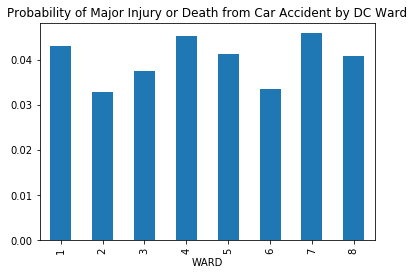

In [102]:
df.groupby('WARD')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()
plt.title('Probability of Major Injury or Death from Car Accident by DC Ward')

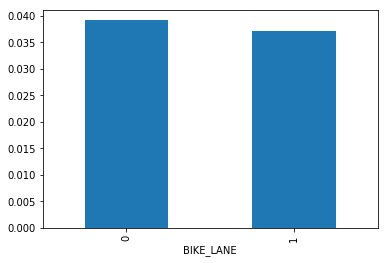

In [104]:
df.groupby('BIKE_LANE')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()

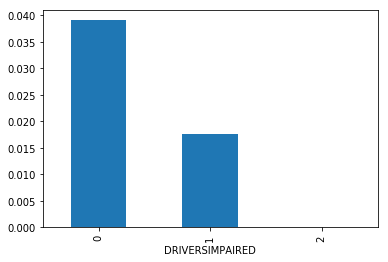

In [111]:
df.groupby('DRIVERSIMPAIRED')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()

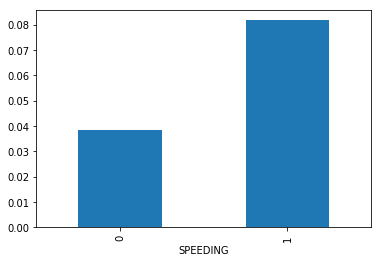

In [113]:
df.groupby('SPEEDING')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()

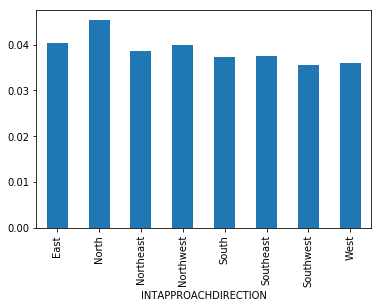

In [116]:
df.groupby('INTAPPROACHDIRECTION')['MAJOR_INJURY_OR_FATAL'].mean().plot.bar()

In [121]:
px.set_mapbox_access_token(open(".mapbox_token").read())

px.scatter_mapbox(df, lat='X', lon= 'Y', color='MAJOR_INJURY_OR_FATAL')

FileNotFoundError: ignored

#Split

In [130]:
test_mask = df['YEAR'] >= 2019
train = df[~test_mask]
test = df[test_mask]

val_mask = train['YEAR'] < 2017
val = train[~val_mask]
train = train[val_mask]


train.shape, val.shape, test.shape

((338806, 64), (96869, 64), (37264, 64))

In [128]:
val.head()

,ADDRESS,AGE,BICYCLISTSIMPAIRED,BIKE_LANE,CRIMEID,DIRECTIONALITY,DRIVERSIMPAIRED,FATAL,FATAL_BICYCLIST,FATAL_DRIVER,FATAL_PEDESTRIAN,FROMDATE,IMPAIRED,INTAPPROACHDIRECTION,INVEHICLETYPE,LATITUDE,LICENSEPLATESTATE,LONGITUDE,MAJORINJURIES_BICYCLIST,MAJORINJURIES_DRIVER,MAJORINJURIES_PEDESTRIAN,MAJORINJURY,MAJOR_INJURY_OR_FATAL,MARID,MAR_ADDRESS,MAR_SCORE,MEASURE,MINORINJURIES_BICYCLIST,MINORINJURIES_DRIVER,MINORINJURIES_PEDESTRIAN,MINORINJURY,MPDLATITUDE,MPDLONGITUDE,NEARESTINTROUTEID,NEARESTINTSTREETNAME,OFFINTERSECTION,OFFSET,PEDESTRIANSIMPAIRED,PERSONID,PERSONTYPE,QUADRANT,REPORTDATE,ROADWAYSEGID,ROUTEID,SPEEDING,SPEEDING_INVOLVED,STREETSEGID,STREETTYPE,TICKETISSUED,TOTAL_BICYCLES,TOTAL_GOVERNMENT,TOTAL_PEDESTRIANS,TOTAL_TAXIS,TOTAL_VEHICLES,UNKNOWNINJURIES_BICYCLIST,UNKNOWNINJURIES_DRIVER,UNKNOWNINJURIES_PEDESTRIAN,VEHICLEID,WARD,X,XCOORD,Y,YCOORD,YEAR
